# QSAR modelling of estrogen receptor alpha ligands

This notebook features a few methods that try to extract activity-structure information from experimental data. The data are saved in the database (DB) and can be loaded into a [pandas](http://pandas.pydata.org) data frame using the [`compound_db_utils`](https://github.com/martin-sicho/MI_ADM/tree/master/compound_db_utils) package:

In [1]:
import os, pickle, math

from compound_db_utils import settings
from compound_db_utils.data_loaders import fetch_learning_data

RELOAD = False # if True, ignore the pickled data and update from DB

def remove_inconsistent(smiles, ic50s):
    """
    Filter that computes a consensus value for molecules that were tested
    multiple times. The consensus is computed as the median of all 
    available values. 
    
    Molecules with too much variation in the data 
    and too few data points are marked as inconsistent and
    removed entirely.
    """
    
    if int(math.log(ic50s.min(), 10)) != int(math.log(ic50s.max(), 10)) and len(ic50s) < 20:
        return False
    else:
        return ic50s.median()

data = None
if os.path.exists('data.pickle') and not RELOAD:
    data = pickle.load(open('data.pickle', 'br'))
else:
    data = fetch_learning_data(
                ['MI-T-d480066c']
                , col_names_map={
                    settings.COMPOUNDS_TABLE + '_smiles' : 'smiles'
                    , settings.BIOACTIVITIES_TABLE + '_value' : 'ic50'
                }
                , create_rdkit_mols=False
                , compute_descriptors=True
                , duplicates_handler= remove_inconsistent
            )
    
pickle.dump(data, open('data.pickle', 'bw'))    

/home/sichom/Software/virtualenvs/miniconda3/envs/MI_ADM/lib/python3.5/site-packages/rdkit/Chem/PeriodicTable.py:131: FutureWarning: split() requires a non-empty pattern match.
  splitLine = blankExpr.split(line)


For each compound, the loaded data provide the canonical [SMILES](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system) string and measured [IC50](https://en.wikipedia.org/wiki/IC50) values. We also chose to compute molecular descriptors for the compounds. Those are saved in the remaining columns (descriptors are computed using the [RDKit](https://rdkit.readthedocs.io/en/latest/) cheminformatics toolkit).

Note that the original dataset may contain duplicate entries, because more experiments were often carried out for one given compound. Here, we decided to remove compounds that show large inconsistencies in their IC50 values and we do not have enough data to safely aggregate the values together.

Because now we only have one SMILES string for each compound, we can use them as the index of the data frame:

In [2]:
data.set_index('smiles', inplace=True)
print(data.shape)
data.head(10)

(1326, 197)


,ic50,MinPartialCharge,MinAbsPartialCharge,NumValenceElectrons,MaxPartialCharge,MaxEStateIndex,NumRadicalElectrons,MinAbsEStateIndex,MinEStateIndex,HeavyAtomMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
smiles,,,,,,,,,,,,,,,,,,,,,
CC[Si](CC)(c1ccc(O)c(C)c1)c1ccc(O)c(C)c1,50.85,-0.507687,0.117970,112,0.117970,9.788292,0,0.357169,-1.826512,276.282,...,0,0,0,0,0,0,0,0,0,0
CCc1c(O)ccc2c1OC(c1ccc(OCCN3CCCCC3)cc1)C(c1ccc(O)cc1)S2,4.70,-0.507967,0.140270,184,0.140270,10.412779,0,0.002980,-0.243942,458.389,...,1,0,0,0,0,0,0,0,0,0
Cc1ccc(S(=O)(=O)N2CCc3cc(O)ccc3C2c2ccc(OCCN3CCCC3)cc2)cc1,24.80,-0.507956,0.243451,184,0.243451,13.740342,0,0.193604,-3.728670,460.385,...,0,1,0,0,0,0,0,0,0,0
CC1=C(c2ccc(O)cc2)C(=O)c2ccc(O)cc21,6.00,-0.507966,0.194032,94,0.194032,12.401821,0,0.043343,-0.043343,240.173,...,0,0,0,0,0,0,0,0,0,0
Oc1ccc2c(c1)S[C@H](c1ccco1)[C@H](c1ccc(OCCN3CCCCC3)cc1)O2,35.00,-0.507920,0.143093,162,0.143093,9.863330,0,0.046139,-0.198525,410.345,...,1,0,0,0,0,0,0,0,0,0
O=c1c2oc3c(Br)cc(O)cc3c2oc2cc(O)cc(O)c12,1260.00,-0.507895,0.239157,110,0.239157,12.512773,0,0.024466,-0.558945,356.063,...,0,0,0,0,0,0,0,0,0,0
Oc1ccc2c(-c3cccc4ccc(O)cc34)noc2c1,1727.00,-0.507943,0.170701,102,0.170701,9.724977,0,0.139596,0.139596,266.191,...,0,0,0,0,0,0,0,0,0,0
Cc1cc(O)cc2cc(-c3ccc(O)cc3)oc12,114.00,-0.507966,0.137489,90,0.137489,9.552571,0,0.225635,0.225635,228.162,...,0,0,0,0,0,0,0,0,0,0
C=Cc1cc(O)cc2ccc(-c3ccc(O)c(F)c3)cc12,527.00,-0.507921,0.164917,104,0.164917,13.477906,0,0.181322,-0.650697,267.194,...,0,0,0,0,0,0,0,0,0,0


Next, we convert the IC50 values to pIC50 which is defined as the negative logarithm with base 10 of the concentration in moles rather than nanomoles (the default unit for the data in our database): 

In [3]:
import numpy as np

data.ic50 = data.ic50.apply(lambda x : -1.0 * np.log10(x / 1.0e9))

Because of the logarithmic scale, the converted data are now much 'nicer' (note that the higher the pIC50 value, the more potent the compound is as opposed to the raw IC50 value where lower value means higher potency):

Original:
count       1326.000000
mean       12355.111644
std       126442.443376
min            0.200000
25%           56.250000
50%          625.500000
75%         7312.457500
max      3500000.000000
Name: ic50, dtype: float64

Converted:
count    1326.000000
mean        6.293268
std         1.357540
min         2.455932
25%         5.135937
50%         6.203773
75%         7.249890
max         9.698970
Name: ic50, dtype: float64


[]

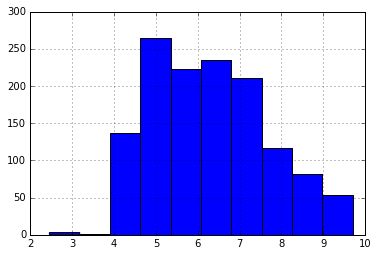

In [4]:
%matplotlib inline
print('Original:')
print(data.ic50.apply(lambda x : np.power(10, - x) * 1.0e9).describe())
print('\nConverted:')
print(data.ic50.describe())
data.ic50.hist().plot()

## Feature Selection

Before we attempt to build a model, we remove some variables that might have and adverse effect on the outcome or no effect at all. 

We also define a couple of helper functions that will help us update our dataset as we go:

In [7]:
def get_removed_feats(data, model):
    """
    This function  finds out the names of the descriptors
    removed by the model.
    """
    
    return data.columns.values[1:][~model.get_support()]

def update_data(data, removed_descriptors):
    """
    Removes the descriptors marked for removal from the data frame.
    """
    data.drop(removed_descriptors, 1, inplace=True)
    print(data.shape)

In the first step we remove features that have zero variance. In other words, the features that have the same value for all of our compounds:

In [8]:
from sklearn.feature_selection import VarianceThreshold

# find the names of the columns with zero variance
var_sel = VarianceThreshold()
var_sel.fit(data.iloc[:,1:])
removed_descriptors = get_removed_feats(data, var_sel)

# update the data frame
update_data(data, removed_descriptors)
data.head(10)

(1326, 172)


,ic50,MinPartialCharge,MinAbsPartialCharge,NumValenceElectrons,MaxPartialCharge,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,HeavyAtomMolWt,MaxAbsPartialCharge,...,fr_pyridine,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
smiles,,,,,,,,,,,,,,,,,,,,,
CC[Si](CC)(c1ccc(O)c(C)c1)c1ccc(O)c(C)c1,7.293709,-0.507687,0.117970,112,0.117970,9.788292,0.357169,-1.826512,276.282,0.507687,...,0,0,0,0,0,0,0,0,0,0
CCc1c(O)ccc2c1OC(c1ccc(OCCN3CCCCC3)cc1)C(c1ccc(O)cc1)S2,8.327902,-0.507967,0.140270,184,0.140270,10.412779,0.002980,-0.243942,458.389,0.507967,...,0,1,0,0,0,0,0,0,0,0
Cc1ccc(S(=O)(=O)N2CCc3cc(O)ccc3C2c2ccc(OCCN3CCCC3)cc2)cc1,7.605548,-0.507956,0.243451,184,0.243451,13.740342,0.193604,-3.728670,460.385,0.507956,...,0,0,1,0,0,0,0,0,0,0
CC1=C(c2ccc(O)cc2)C(=O)c2ccc(O)cc21,8.221849,-0.507966,0.194032,94,0.194032,12.401821,0.043343,-0.043343,240.173,0.507966,...,0,0,0,0,0,0,0,0,0,0
Oc1ccc2c(c1)S[C@H](c1ccco1)[C@H](c1ccc(OCCN3CCCCC3)cc1)O2,7.455932,-0.507920,0.143093,162,0.143093,9.863330,0.046139,-0.198525,410.345,0.507920,...,0,1,0,0,0,0,0,0,0,0
O=c1c2oc3c(Br)cc(O)cc3c2oc2cc(O)cc(O)c12,5.899629,-0.507895,0.239157,110,0.239157,12.512773,0.024466,-0.558945,356.063,0.507895,...,0,0,0,0,0,0,0,0,0,0
Oc1ccc2c(-c3cccc4ccc(O)cc34)noc2c1,5.762708,-0.507943,0.170701,102,0.170701,9.724977,0.139596,0.139596,266.191,0.507943,...,0,0,0,0,0,0,0,0,0,0
Cc1cc(O)cc2cc(-c3ccc(O)cc3)oc12,6.943095,-0.507966,0.137489,90,0.137489,9.552571,0.225635,0.225635,228.162,0.507966,...,0,0,0,0,0,0,0,0,0,0
C=Cc1cc(O)cc2ccc(-c3ccc(O)c(F)c3)cc12,6.278189,-0.507921,0.164917,104,0.164917,13.477906,0.181322,-0.650697,267.194,0.507921,...,0,0,0,0,0,0,0,0,0,0


In the next step, we perform univariate regression tests on the variables (regressors). The cross-correlation between the target variable and
each regressor is evaluated and converted into a p-value and only the top 50% of variables are selected:

In [9]:
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_regression

# keep only the descriptors that show significant 
# correlation with the target variable (pIC50)
regre_sele = SelectPercentile(f_regression, percentile=50)
regre_sele.fit(data.iloc[:,1:], data.ic50)
removed_descriptors = get_removed_feats(data, regre_sele)

# update the data frame
update_data(data, removed_descriptors)
data.head(10)

(1326, 86)


,ic50,MinPartialCharge,MinAbsPartialCharge,NumValenceElectrons,MaxPartialCharge,HeavyAtomMolWt,MaxAbsPartialCharge,ExactMolWt,MolWt,BalabanJ,...,fr_aniline,fr_benzene,fr_ester,fr_ether,fr_furan,fr_methoxy,fr_phenol,fr_phenol_noOrthoHbond,fr_piperdine,fr_pyridine
smiles,,,,,,,,,,,,,,,,,,,,,
CC[Si](CC)(c1ccc(O)c(C)c1)c1ccc(O)c(C)c1,7.293709,-0.507687,0.117970,112,0.117970,276.282,0.507687,300.154557,300.474,2.631242,...,0,2,0,0,0,0,2,2,0,0
CCc1c(O)ccc2c1OC(c1ccc(OCCN3CCCCC3)cc1)C(c1ccc(O)cc1)S2,8.327902,-0.507967,0.140270,184,0.140270,458.389,0.507967,491.213030,491.653,1.368494,...,0,3,0,2,0,0,2,2,1,0
Cc1ccc(S(=O)(=O)N2CCc3cc(O)ccc3C2c2ccc(OCCN3CCCC3)cc2)cc1,7.605548,-0.507956,0.243451,184,0.243451,460.385,0.507956,492.208279,492.641,1.434939,...,0,3,0,1,0,0,1,1,0,0
CC1=C(c2ccc(O)cc2)C(=O)c2ccc(O)cc21,8.221849,-0.507966,0.194032,94,0.194032,240.173,0.507966,252.078644,252.269,2.183659,...,0,2,0,0,0,0,2,2,0,0
Oc1ccc2c(c1)S[C@H](c1ccco1)[C@H](c1ccc(OCCN3CCCCC3)cc1)O2,7.455932,-0.507920,0.143093,162,0.143093,410.345,0.507920,437.166079,437.561,1.294169,...,0,2,0,2,1,0,1,1,1,0
O=c1c2oc3c(Br)cc(O)cc3c2oc2cc(O)cc(O)c12,5.899629,-0.507895,0.239157,110,0.239157,356.063,0.507895,361.942600,363.119,2.328321,...,0,2,0,0,1,0,3,3,0,0
Oc1ccc2c(-c3cccc4ccc(O)cc34)noc2c1,5.762708,-0.507943,0.170701,102,0.170701,266.191,0.507943,277.073893,277.279,2.063442,...,0,3,0,0,0,0,2,2,0,0
Cc1cc(O)cc2cc(-c3ccc(O)cc3)oc12,6.943095,-0.507966,0.137489,90,0.137489,228.162,0.507966,240.078644,240.258,2.188698,...,0,2,0,0,1,0,2,2,0,0
C=Cc1cc(O)cc2ccc(-c3ccc(O)c(F)c3)cc12,6.278189,-0.507921,0.164917,104,0.164917,267.194,0.507921,280.089958,280.298,2.223360,...,0,3,0,0,0,0,2,2,0,0


Next, we train a generlized linear model and select only the descriptors that have non-zero coefficients:

In [15]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

lasso = Lasso(
    normalize=False
    , fit_intercept=True
    , copy_X=True
    , random_state=42
    , max_iter=2e3
).fit(data.iloc[:,1:], data.ic50)
sel_from_mod = SelectFromModel(lasso, prefit=True)

removed_descriptors = get_removed_feats(data, sel_from_mod)

# update the data frame
update_data(data, removed_descriptors)
data.head(10)

(1326, 12)


,ic50,ExactMolWt,BertzCT,PEOE_VSA10,PEOE_VSA7,PEOE_VSA9,SMR_VSA9,SlogP_VSA11,SlogP_VSA6,TPSA,EState_VSA4,EState_VSA7
smiles,,,,,,,,,,,,
CC[Si](CC)(c1ccc(O)c(C)c1)c1ccc(O)c(C)c1,7.293709,300.154557,592.161740,19.572896,37.107112,0.000000,11.499024,11.499024,36.398202,40.46,23.215095,25.980209
CCc1c(O)ccc2c1OC(c1ccc(OCCN3CCCCC3)cc1)C(c1ccc(O)cc1)S2,8.327902,491.213030,1126.668757,35.708896,79.877083,10.145422,22.998047,22.998047,65.559154,62.16,39.629618,37.255573
Cc1ccc(S(=O)(=O)N2CCc3cc(O)ccc3C2c2ccc(OCCN3CCCC3)cc2)cc1,7.605548,492.208279,1267.314361,18.105906,92.364272,10.937324,11.499024,11.499024,71.625521,70.08,47.637587,49.388307
CC1=C(c2ccc(O)cc2)C(=O)c2ccc(O)cc21,8.221849,252.078644,709.273947,11.499024,53.955580,0.000000,11.499024,11.499024,42.464569,57.53,16.700008,6.923737
Oc1ccc2c(c1)S[C@H](c1ccco1)[C@H](c1ccc(OCCN3CCCCC3)cc1)O2,7.455932,437.166079,983.266410,40.969569,73.959177,11.158646,17.248535,17.248535,70.173101,55.07,34.262962,30.331835
O=c1c2oc3c(Br)cc(O)cc3c2oc2cc(O)cc(O)c12,5.899629,361.942600,1138.093464,28.217780,28.062678,9.858944,17.248535,17.248535,42.367027,104.04,6.066367,0.000000
Oc1ccc2c(-c3cccc4ccc(O)cc34)noc2c1,5.762708,277.073893,972.269137,17.192952,35.037917,0.000000,22.756403,11.499024,59.120399,66.49,21.722124,24.265468
Cc1cc(O)cc2cc(-c3ccc(O)cc3)oc12,6.943095,240.078644,708.431960,22.842291,54.951758,0.000000,22.822723,11.499024,46.881720,53.60,27.856395,12.990104
C=Cc1cc(O)cc2ccc(-c3ccc(O)c(F)c3)cc12,6.278189,280.089958,853.206408,5.749512,57.794638,0.000000,22.625927,11.499024,55.109872,40.46,21.899351,18.199101


## PCA Analysis

Now that we extracted a limited subset of features that should be 
most relevant to the activity-structure relationship, we can try
to project the molecules to 3D space and see if there is any correlation between their postion and the pIC50 value:

In [43]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=5)
pca.fit(data.iloc[:,1:])
pca_result = pca.transform(data.iloc[:,1:])
eigen_values = pca.explained_variance_ratio_

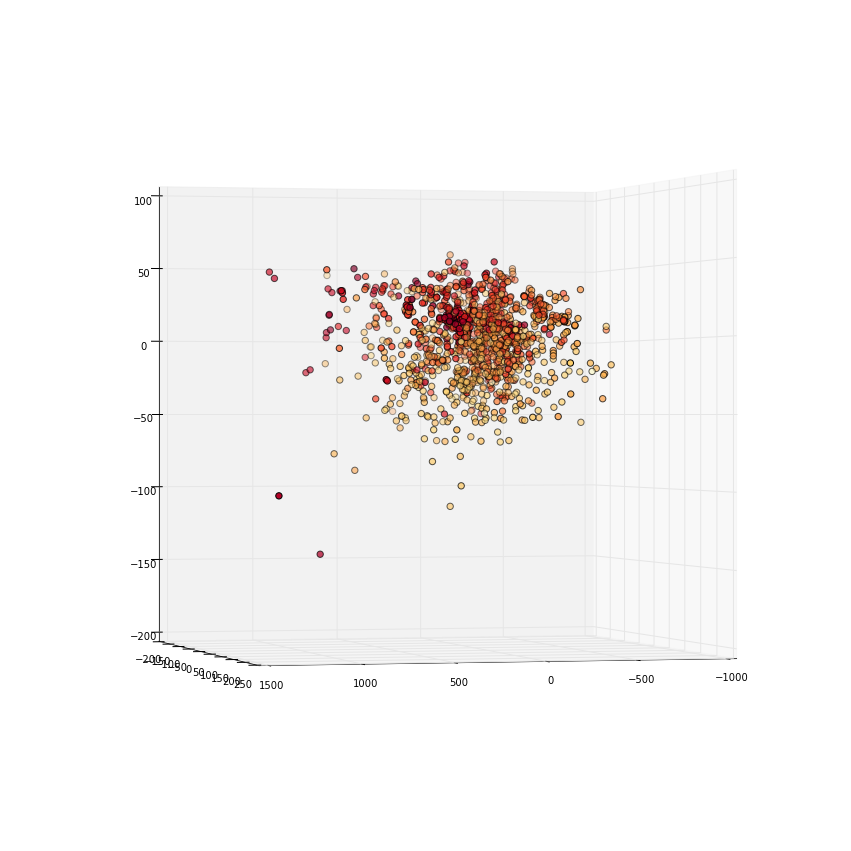

In [44]:
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

plt.rcParams["figure.figsize"] = [15, 15]
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(
    pca_result[:,0]
    , pca_result[:,1]
    , pca_result[:,2]
    , c=data.ic50
    , s=40
    , cmap='YlOrRd' # red are the compounds with higher values of pIC50
)
ax.view_init(elev=0, azim=75)
plt.show()

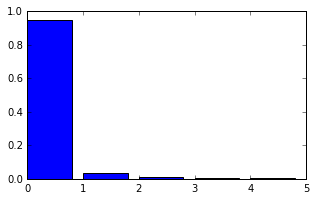

In [45]:
plt.rcParams["figure.figsize"] = [5, 3]

plt.bar(range(pca_result.shape[1]), eigen_values)
plt.show()

## Model Building

Because we will be building a SVM model, we first need to standardize 
the features. We do so by removing the mean and scaling to unit variance:

In [58]:
from sklearn.preprocessing import StandardScaler
from pandas import DataFrame

scaler = StandardScaler(copy=False)
scaler.fit(data.iloc[:,1:])
scaled_descs = DataFrame(scaler.transform(data.iloc[:,1:]), columns=data.iloc[:,1:].columns)
scaled_descs.head(10)

,ExactMolWt,BertzCT,PEOE_VSA10,PEOE_VSA7,PEOE_VSA9,SMR_VSA9,SlogP_VSA11,SlogP_VSA6,TPSA,EState_VSA4,EState_VSA7
0,-0.661515,-1.299228,0.455921,-0.647195,-1.217711,-0.313279,0.215524,-0.715685,-1.108720,-0.046671,0.396941
1,1.496400,0.719986,1.987768,1.316570,0.035361,0.824937,1.733497,0.803302,-0.165579,0.910610,1.051019
2,1.507641,1.251305,0.316655,1.889914,0.133170,-0.313279,0.215524,1.119298,0.178645,1.377627,1.754832
3,-1.204509,-0.856812,-0.310559,0.126395,-1.217711,-0.313279,0.215524,-0.399689,-0.366812,-0.426625,-0.708514
4,0.885966,0.178253,2.487182,1.044852,0.160506,0.255829,0.974510,1.043641,-0.473730,0.597631,0.649377
5,0.036352,0.763146,1.276610,-1.062466,-0.000022,0.255829,0.974510,-0.404770,1.654638,-1.046769,-1.110156
6,-0.922200,0.136709,0.229985,-0.742201,-1.217711,0.801018,0.215524,0.467909,0.022614,-0.133740,0.297470
7,-1.340043,-0.859993,0.766297,0.172134,-1.217711,0.807583,0.215524,-0.169601,-0.537620,0.224006,-0.356608
8,-0.888135,-0.313076,-0.856380,0.302664,-1.217711,0.788103,0.215524,0.259001,-1.108720,-0.123404,-0.054437
9,1.518755,0.669092,1.987768,1.572013,0.035361,0.824937,1.733497,1.119298,0.713671,2.098436,1.001283


Next, we create the datasets for cross-validation and testing:

In [75]:
from sklearn.cross_validation import train_test_split

descriptors_train, descriptors_test, pIC50_train, pIC50_test = train_test_split(
    scaled_descs
    , data.ic50
    , test_size=0.4
    , random_state=42
)

and build the model:

In [76]:
from sklearn.cross_validation import cross_val_score
from sklearn.svm import SVR

model = SVR(C=5.0, kernel='rbf', epsilon=0.4)
model.fit(descriptors_train, pIC50_train)

SVR(C=5.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.4, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

We get the cross-validation scores (coefficient of determination) and the correlation between the predicted and true values of pIC50:

In [77]:
scores = cross_val_score(model, descriptors_train, pIC50_train, cv=5)

print("Mean R^2: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print("Mean R: %0.2f (+/- %0.2f)" % (np.sqrt(scores).mean(), np.sqrt(scores).std() * 2))

Mean R^2: 0.63 (+/- 0.11)
Mean R: 0.79 (+/- 0.07)


In [80]:
print("R^2: %0.2f" % model.score(descriptors_test, pIC50_test))
print("R: %0.2f" % np.sqrt(model.score(descriptors_test, pIC50_test)))

R^2: 0.60
R: 0.77


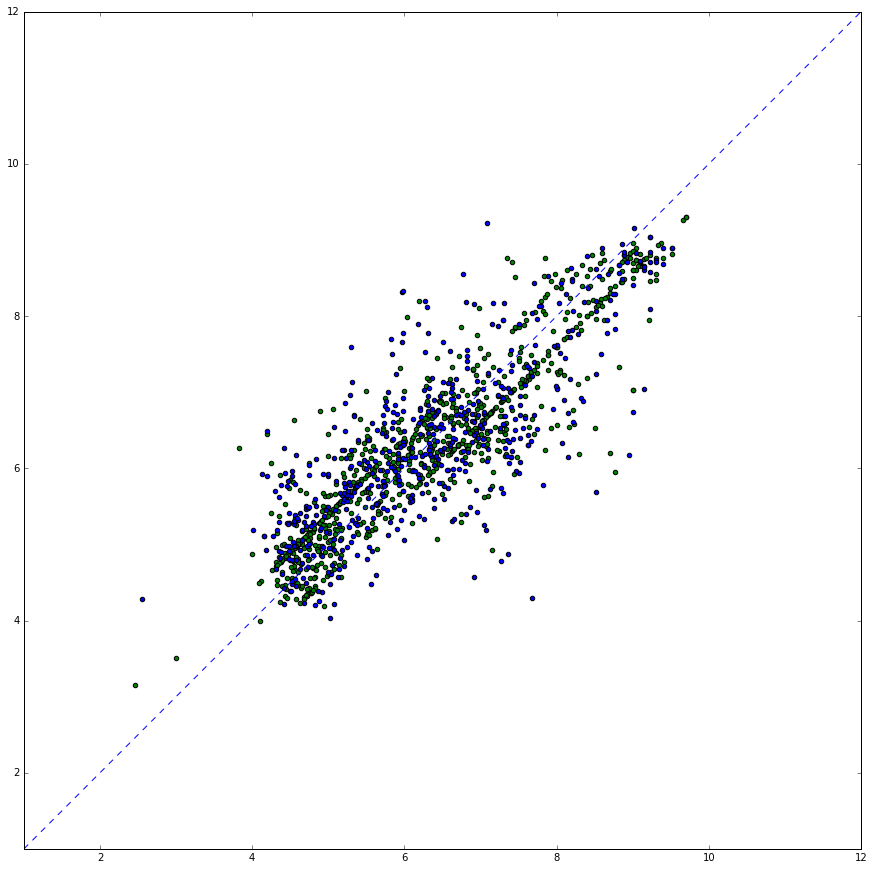

In [81]:
plt.rcParams["figure.figsize"] = [15, 15]
span = (1,12)
axes = plt.gca()
axes.set_xlim(span)
axes.set_ylim(span)

plt.plot((span[0],span[1]), (span[0],span[1]), linestyle='--')

plt.scatter(
    pIC50_train
    , model.predict(descriptors_train)
    , c='green'
    , s=20
)

plt.scatter(
    pIC50_test
    , model.predict(descriptors_test)
    , c='blue'
    , s=20
)

[]

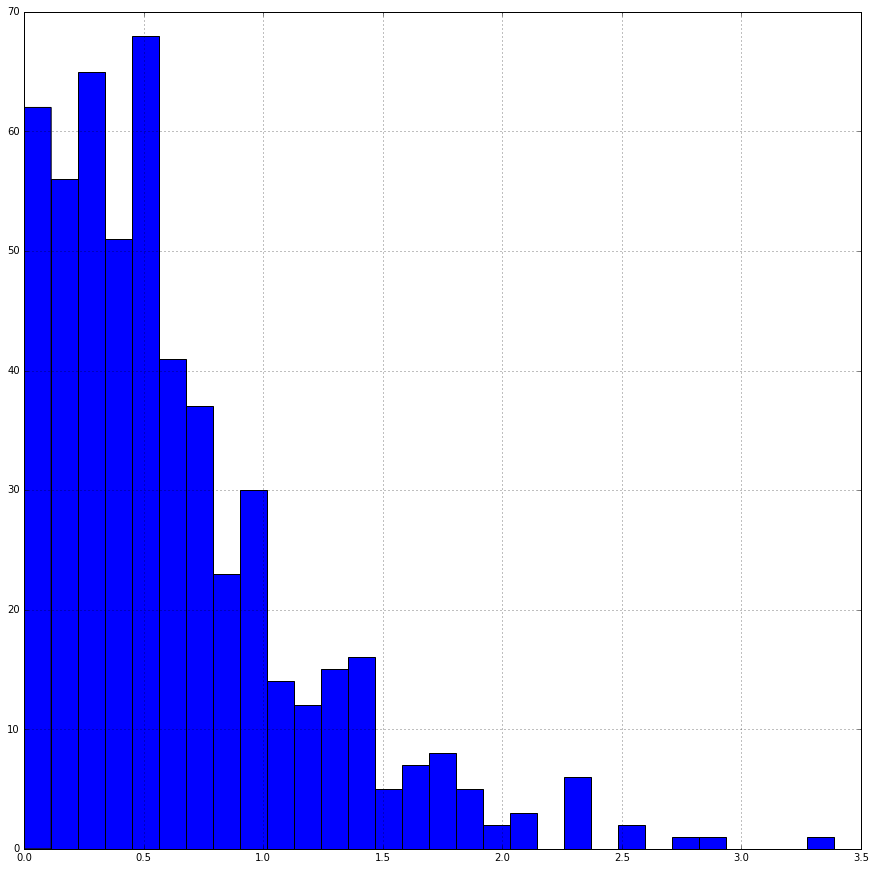

In [90]:
(pIC50_test - model.predict(descriptors_test)).abs().hist(bins=30).plot()